# s1 backscatter for lake ice cover

In [28]:
# use `pro` env
from dask.distributed import LocalCluster
from functools import reduce
import geopandas as gpd
from glob import glob
import numpy as np
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import rioxarray as rio
import seaborn as sns
import stackstac
import xarray as xr
import lakeIce_utils as liU
from tqdm import tqdm
from scipy.stats import linregress
import statsmodels.api as sm

import importlib
importlib.reload(liU)

<module 'lakeIce_utils' from '/scratch/s1759665/paper2/src/lakeIce_utils.py'>

In [18]:
centrelines = gpd.read_file('../data/streams_v3.geojson')

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})

lakes = gpd.read_file('../data/lake_areas.geojson')

lakes = lakes.sjoin_nearest(centrelines)
lakes = (lakes
            .sort_values(by='id')
            .drop(columns=['index_right', 'name', 'lake_land'])
            .to_crs(4326)
)

lakes['lat'] = lakes.centroid.y

/tmp/ipykernel_4018597/4255146022.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lakes['lat'] = lakes.centroid.y


## freeze up thaw out

In [19]:
df = pd.concat([pd.read_parquet(f) for f in glob('../results/lakeIce/*quantiles.parquet')])
df['year'] = df.index.year
df['month'] = df.index.month
df = df.sort_index()

### using simple difference method

In [84]:
def futo(s):
    first_half = s.month <= 7
    second_half = s.month > 7
    first_min = s[first_half].groupby('year')['delta_hh_0.5'].idxmin()
    second_min = s[second_half].groupby('year')['delta_hh_0.5'].idxmin()

    
    return pd.merge(s.loc[first_min, 'time'].set_axis(first_min.index).rename('thaw'),
                    s.loc[second_min, 'time'].set_axis(second_min.index).rename('freeze'),
                    left_index=True, right_index=True)

In [85]:
diff = (df
        .groupby('id')['hh_0.5']
        .apply(lambda q: q.diff())
        .reset_index()
        .rename(columns={'hh_0.5': 'delta_hh_0.5'})
        )

diff['month'] = diff.time.dt.month
diff['year'] = diff.time.dt.year

free_thaw = (diff
             .groupby('id')[['id', 'month', 'delta_hh_0.5', 'time', 'year']]
             .apply(lambda q: futo(q))
             )
free_thaw['thaw_doy'] = free_thaw['thaw'].dt.day_of_year

free_thaw['freeze_doy'] = free_thaw['freeze'].dt.day_of_year

free_thaw = pd.merge(
    free_thaw.reset_index(),
    lakes['lat'],
    left_on='id',
    right_index=True
    )


thaw_doy
2.54 ± 0.88 days/ ° latitude

freeze_doy
-2.79 ± 0.75 days/ ° latitude


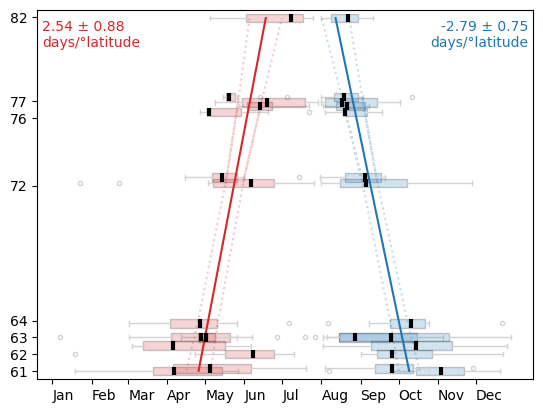

In [86]:
fig, ax = plt.subplots()

for id, grp in free_thaw.groupby('id'):
    
    free_box = ax.boxplot(grp.freeze_doy,
                          positions=grp.lat.unique().round(2),
                          vert=False,
                          widths=0.5,
                          patch_artist=True,
                          whiskerprops={'color':'lightgray'},
                          flierprops={'marker':'.', 'markeredgecolor': 'lightgray'},
                          medianprops={'color':'k', 'lw': 3},
                          capprops={'color':'lightgray'})
    
    thaw_box = ax.boxplot(grp.thaw_doy,
                          positions=grp.lat.unique().round(2),
                          vert=False,
                          widths=0.5,
                          patch_artist=True,
                          whiskerprops={'color':'lightgray'},
                          flierprops={'marker':'.', 'markeredgecolor': 'lightgray'},
                          medianprops={'color':'k', 'lw': 3},
                          capprops={'color':'lightgray'})
    
    thaw_box['boxes'][0].set_facecolor('tab:red')
    thaw_box['boxes'][0].set_alpha(0.2)

    
    free_box['boxes'][0].set_facecolor('tab:blue')
    free_box['boxes'][0].set_alpha(0.2)

lats = lakes.lat.round().unique().astype(int)
_ = ax.set_yticks(lats, labels=lats)

month_starts = pd.date_range('2020-01-01', '2020-12-31', freq='MS')
_ = ax.set_xticks(month_starts.day_of_year, labels=month_starts.strftime('%b'), ha='left')


for c, var, pos, ha in zip(['tab:red', 'tab:blue'], ['thaw_doy', 'freeze_doy'], [(0.01,0.9), (0.99, 0.9)], ['left', 'right']):
	Y = free_thaw[var]
	X = free_thaw['lat']
	X = sm.add_constant(X)

	model = sm.OLS(Y,X).fit()
 
	pred = model.get_prediction(X)
	pred_summary = pred.summary_frame(alpha=0.05)

	ciLower = pred_summary['mean_ci_lower']
	ciUpper = pred_summary['mean_ci_upper']

	conf_int = model.conf_int()
	lower, upper = conf_int.loc['lat']
	pm = (upper - lower) / 2

	ax.plot(model.fittedvalues, free_thaw['lat'], c=c)
	ax.plot(ciLower, free_thaw['lat'], c=c, alpha=0.25, ls=':')
	ax.plot(ciUpper, free_thaw['lat'], c=c, alpha=0.25, ls=':')
 
	print(f'\n{var}')
	print(f"{model.params['lat']:.2f} ± {pm:.2f} days/ ° latitude")
 
	ax.annotate(
		f"{model.params['lat']:.2f} ± {pm:.2f}\ndays/°latitude",
		xy=pos,
		xycoords='axes fraction',
		ha=ha,
		c=c
	)

## normalizing backscatter by incidence angle

In [ ]:
df = pd.concat([pd.read_parquet(f) for f in glob('../results/lakeIce/*_sample.parquet')])
df = df.melt(['xy', 'time', 'sat:relative_orbit', 'angle', 'month', 'id', 'region'])
df = df.rename(columns={
    'variable': 'band',
    'value': 'dB'
})
df['band'] = df['band'].str.replace('dB_', '')
df['angle'] = np.degrees(df['angle'])

In [ ]:
# get outliers (5th and 95th percentile) and ditch 'em before fitting model
outliers = (df
 .groupby('band')
 .apply(lambda q: np.quantile(q['dB'], [0.05, 0.95]))
 .apply(pd.Series)
 .rename(columns={0: 'q02', 1: 'q98'})
)

idxs = []
for band in outliers.index:
    idx = (
        (df['band'] == band)
        &
        (df['dB'] > outliers.loc[band, 'q02'])
        &
        (df['dB'] < outliers.loc[band, 'q98'])
    )
    idxs.append(idx)
    
idx = np.logical_or(*idxs)

In [ ]:
## backscatter dependence on angle by band and month
lr = (df[idx].groupby(['band', 'month'])[['angle', 'dB']].apply(lambda q: pd.Series(linregress(x = q['angle'],
                                                              y = q['dB'])))
      .reset_index()
      .rename(columns = {0:'slope',
                         1:'intercept',
                         2:'rvalue',
                         3:'pvalue',
                         4:'stderr'}))


minang, maxang = df['angle'].agg(['min', 'max'])
incident_angles = np.arange(minang//1, 1 + maxang//1)
month_norm = Normalize(1, 12)

print(lr.loc[
    lr['slope'].abs().sort_values(ascending=False).index
    ].to_markdown())

band_style = {
    'hh': ':',
    'hv': '-'
}
fig, ax = plt.subplots()

for fit in lr.itertuples():
    if fit.month == 6:
        label = fit.band
    else:
        label = None
    ax.plot(incident_angles,
            incident_angles * fit.slope + fit.intercept,
            c=plt.get_cmap('twilight')(month_norm(fit.month)),
            ls=band_style[fit.band],
            label=label)

ax.legend()

sm = ScalarMappable(month_norm, cmap='twilight')
plt.colorbar(sm, ax=ax, label='month')

ax.set(xlabel='Incidence Angle (degrees)',
       ylabel='Backscatter (dB)')

In [ ]:
## backscatter dependence on angle by BAND, only

lr = (df[idx].groupby(['band'])[['angle', 'dB']].apply(lambda q: pd.Series(linregress(x = q['angle'],
                                                              y = q['dB'])))
      .reset_index()
      .rename(columns = {0:'slope',
                         1:'intercept',
                         2:'rvalue',
                         3:'pvalue',
                         4:'stderr'}))

print(lr.to_markdown())

minang, maxang = df['angle'].agg(['min', 'max'])
incident_angles = np.arange(minang//1, 1 + maxang//1)

band_style = {
    'hh': ':',
    'hv': '-'
}
fig, ax = plt.subplots()
for fit in lr.itertuples():    
    ax.plot(incident_angles,
            incident_angles * fit.slope + fit.intercept,
            ls=band_style[fit.band],
            label=fit.band)
ax.legend()

ax.set(xlabel='Incidence Angle (degrees)',
       ylabel='Backscatter (dB)')

# fold

In [ ]:
# doesn't need running again because saved output to: '../results/s1_lake_backscatter.parquet'
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
medians = []
ids = []
for row in tqdm(lakes.to_crs(4326).sample(1).itertuples()):
    
    search = catalog.search(collections=['sentinel-1-rtc'],
                            intersects=row.geometry)
    
    s1items = search.item_collection()
    
    # get most common projection
    vals, cnts = np.unique([item.properties['proj:epsg'] for item in s1items] ,return_counts=True)
    epsg = int(vals[np.argmax(cnts)])
    
    # stack & clip
    ds = stackstac.stack(planetary_computer.sign(s1items),
                        epsg=epsg,
                        bounds_latlon=row.geometry.bounds)
    
    mask = (make_geocube(lakes.to_crs(4326).loc[lakes['id']==row.id],
                          fill=np.nan,
                          like=ds)['id']
             .rename('mask'))
    
    # apply mask and convert to dB
    ds_db = xr.where(mask==row.id,
                     10 * np.log10(ds),
                     np.nan)

    median = (ds_db
              .median(dim=['y','x'], skipna=True)
              .rename('dB'))
    
    medians.append(median) # consider making this a future
    ids.append(row.id)
    
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    computed_medians = dask.compute(*medians)
    dfs = []
    for m_ds, id in zip(computed_medians, ids):
        _df = m_ds.to_dataframe()
        _df['myid'] = id
        dfs.append(_df)
    
    df = pd.concat(dfs).reset_index().set_index('time')
    
df.to_parquet('../results/s1_lake_backscatter.parquet')

using: 
- https://github.com/egagli/generate_sentinel1_local_incidence_angle_maps/blob/882b9940a843c6dc3040f992ad6bed14201a2f5c/generate_lia.py#L61
- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/rtc-qualitative-assessment.ipynb
- and sarsen

## get s1 data

In [ ]:
df = pd.read_parquet('../results/s1_lake_backscatter.parquet')
df = df.merge(centrelines['SUBREGION1'], left_on='myid', right_index=True)

In [ ]:
fg = sns.relplot(data=df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d').median().reset_index(),
                 x='time',
                 y='dB',
                 row='SUBREGION1',
                 hue='SUBREGION1',
                 style='myid',
                 palette='tab10',
                 col='band',
                 col_order=['hh'],
                 kind='line',
                 aspect=2,
                #  height=10
                 )

fg.set(ylim=(-22,2))

In [ ]:
df['doy'] = df.index.day_of_year
df['year'] = df.index.year

In [ ]:
smoothed = df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d', min_periods=3, center=True).median().reset_index()
smoothed['doy'] = smoothed['time'].dt.day_of_year
smoothed['year'] = smoothed['time'].dt.year


In [ ]:
sns.relplot(data=smoothed.loc[
    (smoothed['band'].isin(['hh']))
    & (smoothed['year'].isin([2018, 2024]))
    ],
            x='doy',
            y='dB',
            hue='year',
            col='SUBREGION1',
            col_wrap=3,
            # row='SUBREGION1',
            kind='line')